In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

Срок выполнения задания: 13 апреля 17:00.


### Задание
Вам предстоит разработать дизайн эксперимента по тестированию монетизационных продуктов.
В конечном счёте, в монтизационных продуктах нас всегда интересует увеличение выручки, 
но к сожалению не всегда мы можем зафиксировать изменение именно этой метрики.

#### Кейс
Вы аналитик в продуктовой дискавери команде.
На текущий момент приближается начало нового квартала и вам необходимо спланировать
эксперименты в нём.

У вас есть два продукта:
- один базовый продукт, который предоставляет минимальный набор услуг на вашем ресурсе;
- один продвинутый продукт, который предоставляет расширенный набор услуг.

На текущий момент на квартал у вашей команды есть для проверки две гипотезы:
- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта


#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.


#### Формализуйте гипотезы (4 балла):

- Опишите метрики и статистики, изменение которых вы ожидаете;
- Предположите какое относительное изменение этих статистик в процентах вы ожидаете.

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала (4 балла):

- Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность;
- Определите наиболее оптимальный план экспериментов. Обоснуйте, почему вы его считаете оптимальным.


#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

product - тип продукта

amount - сумма покупок

transactions - количество транзакций


In [71]:
df = pd.read_csv('user_transactions.csv')
df['event_date']=df.event_date.apply(date_converter)

In [72]:
df.head()

,event_date,user_id,product,amount,transactions
0,2020-09-29,40746820883461494,basic,95.0,1
1,2020-09-29,41102328408008828,advanced,279.0,1
2,2020-09-29,63464894315144075,basic,64.0,1
3,2020-09-29,111526991873455341,basic,399.0,1
4,2020-09-29,169522572963414231,basic,199.0,1


In [73]:
df.describe()

,event_date,user_id,amount,transactions
count,1278186,1.278186e+06,1.278186e+06,1.278186e+06
mean,2020-11-15 11:45:56.945233152,4.614241e+18,2.394618e+02,1.292690e+00
min,2020-09-29 00:00:00,1.809139e+12,8.000000e+00,1.000000e+00
25%,2020-10-23 00:00:00,2.311730e+18,8.900000e+01,1.000000e+00
50%,2020-11-17 00:00:00,4.622499e+18,1.490000e+02,1.000000e+00
75%,2020-12-09 00:00:00,6.906575e+18,2.590000e+02,1.000000e+00
max,2020-12-29 00:00:00,9.223367e+18,1.081860e+05,7.680000e+02
std,NaN,2.657074e+18,3.719033e+02,1.511153e+00


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278186 entries, 0 to 1278185
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   event_date    1278186 non-null  datetime64[ns]
 1   user_id       1278186 non-null  int64         
 2   product       1278186 non-null  object        
 3   amount        1278186 non-null  float64       
 4   transactions  1278186 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 48.8+ MB


basic: 77.487%
advanced: 22.513%


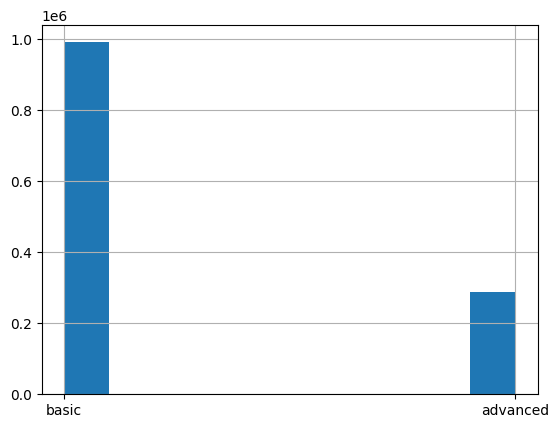

In [75]:
df['product'].hist()

print(f"basic: {round(df[df['product'] == 'basic'].shape[0]*100/len(df['product']), 3)}%")
print(f"advanced: {round(df[df['product'] == 'advanced'].shape[0]*100/len(df['product']), 3)}%")

Посмотрим на количество транзакций

In [76]:
df.groupby('transactions')['user_id'].count().reset_index()

,transactions,user_id
0,1,1094324
1,2,117833
2,3,32360
3,4,13385
4,5,6647
...,...,...
84,164,1
85,196,1
86,209,1
87,227,1


С точки зрения дополнительного информирования об эффективности услуг, как заметить, что это стимулирует пользователя на покупку? Можно смотреть на ARPU, также среднее количество транзакций на пользователя.

С точки зрения повышения цены базового продукта, можно добавить можно также смотреть количество пользователей в группе 'advanced' (количество пользователей, хотя бы раз воспользовавшиеся 'advanced')

Есть огромная часть выборки, юзеры которой совершили одну транзакцию, а есть те, кто совершали две и более - их уже в 10 раз меньше, а есть и те кто совершали много транзакций, но они представлены в единственном экземпляре) Наверное их надо как-то обработать.

In [77]:
df_user = df[['user_id', 'transactions', 'amount']].groupby('user_id').sum().sort_values(by=['amount'], ascending=False).reset_index()
df_user.head(30)
df_user.describe()

,user_id,transactions,amount
count,4.469350e+05,446935.000000,446935.000000
mean,4.606319e+18,3.696954,684.835016
std,2.664531e+18,16.522523,4082.887730
min,1.809139e+12,1.000000,8.000000
25%,2.296971e+18,1.000000,89.000000
50%,4.604575e+18,1.000000,189.000000
75%,6.914117e+18,2.000000,420.000000
max,9.223367e+18,3070.000000,506454.000000


In [78]:
np.quantile(df_user['amount'].to_numpy(), 0.97)

3316.0

In [79]:
np.quantile(df_user['transactions'].to_numpy(), 0.9975)

95.0

Дваайте уберем большие суммы, это выбросы.

<Axes: >

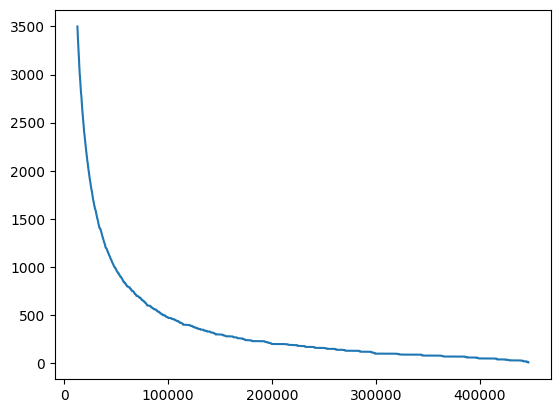

In [80]:
df_user[df_user['amount'] < 3500]['amount'].plot()

Выручка по юзерам имеет экспоненциальное распределение

<Axes: >

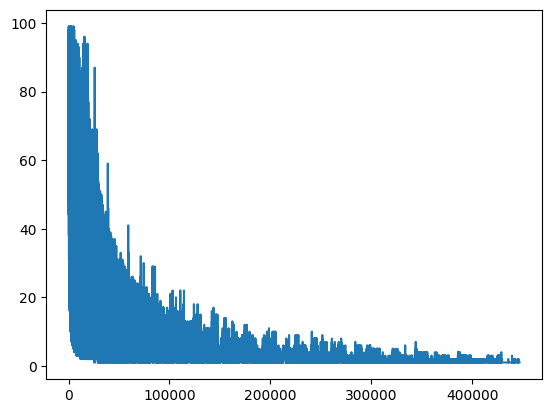

In [81]:
df_user[df_user['transactions'] < 100]['transactions'].plot()

Количество транзакций по пользователям тоже имеет экспоненциальное распределение

In [82]:
print(f"{len(df['user_id'].unique())} уникальных пользователей")
print(f"Всего записей {df.shape[0]}")

446935 уникальных пользователей
Всего записей 1278186


In [83]:
df_user = df_user[(df_user['transactions'] < 100) & (df_user['amount'] < 3500)]
godd_users = df_user['user_id']
df_user.describe()

,user_id,transactions,amount
count,4.343090e+05,434309.000000,434309.000000
mean,4.605889e+18,2.423282,357.632167
std,2.665094e+18,3.541672,501.844937
min,1.809139e+12,1.000000,8.000000
25%,2.295216e+18,1.000000,89.000000
50%,4.603962e+18,1.000000,178.000000
75%,6.914473e+18,2.000000,392.000000
max,9.223367e+18,96.000000,3499.000000


In [84]:
df_for_adv = df # Это чтобы сохранить для анализа количества advanced 
df = df[df.user_id.isin(godd_users)]

Посмотрим на временную зависимость

In [85]:
df.describe()

,event_date,user_id,amount,transactions
count,942831,9.428310e+05,942831.000000,942831.000000
mean,2020-11-15 12:36:35.347415808,4.613333e+18,164.740944,1.116269
min,2020-09-29 00:00:00,1.809139e+12,8.000000,1.000000
25%,2020-10-23 00:00:00,2.302894e+18,79.000000,1.000000
50%,2020-11-17 00:00:00,4.614278e+18,119.000000,1.000000
75%,2020-12-09 00:00:00,6.919481e+18,199.000000,1.000000
max,2020-12-29 00:00:00,9.223367e+18,3495.000000,34.000000
std,NaN,2.665507e+18,158.343991,0.483801


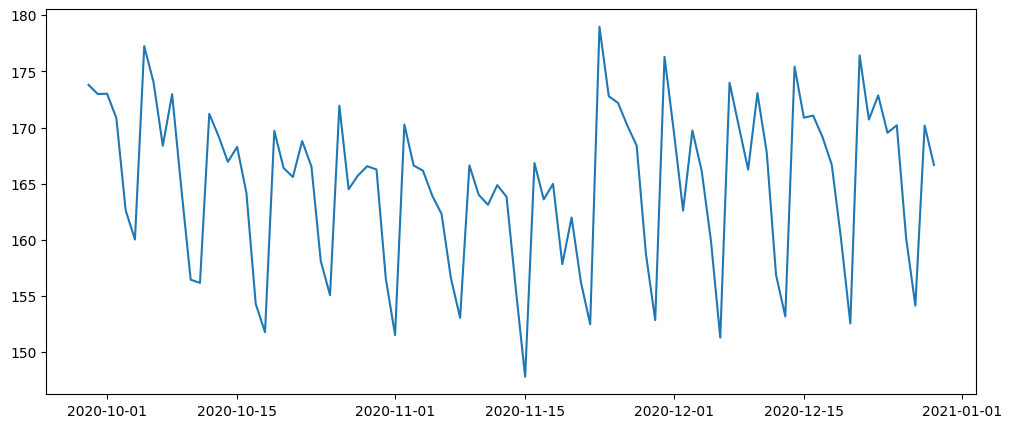

In [86]:
revenue = df[df['user_id'].isin(godd_users)][['amount', 'event_date']].groupby('event_date').sum().reset_index()
users = df[df['user_id'].isin(godd_users)][['user_id', 'event_date']].groupby('event_date').nunique().reset_index()
revenue['amount'] = revenue['amount'] / users['user_id']

plt.figure(figsize=(12, 5))
plt.plot(revenue['event_date'], revenue['amount'])

Явно видим сезональность в выручке, на глаз это недельная сезональность. Это график средней прибыли с юзера в день.

In [87]:
revenue.amount.mean()

164.9912840836109

In [88]:
users.user_id.mean()

10201.402173913044

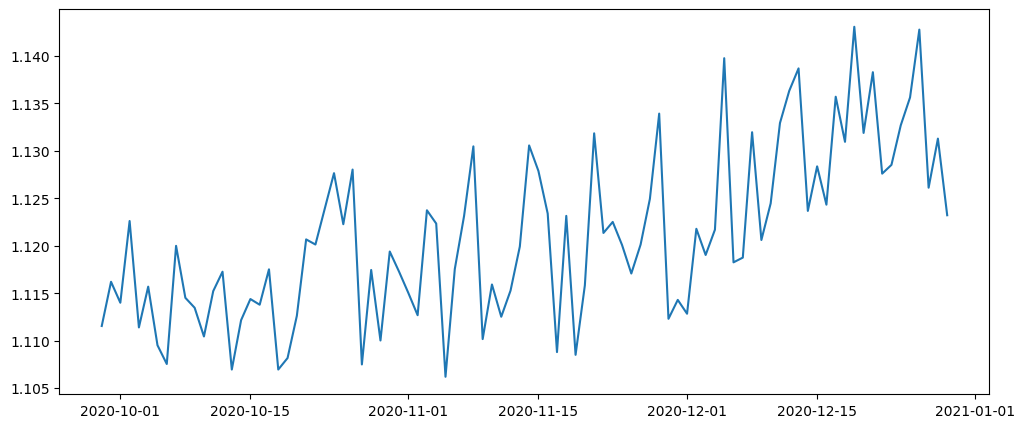

In [89]:
transactions = df[df['user_id'].isin(godd_users)][['transactions', 'event_date']].groupby('event_date').sum().reset_index()
transactions['transactions'] = transactions['transactions'] / users['user_id']

plt.figure(figsize=(12, 5))
plt.plot(transactions['event_date'], transactions['transactions'])

Это график числа транзакций на 1 юзера в день.

In [90]:
transactions.transactions.mean()

1.1209709898886795

In [91]:
df[df['user_id'].isin(godd_users)][['amount', 'transactions', 'event_date']].groupby('event_date').sum().reset_index().corr()

,event_date,amount,transactions
event_date,1.000000,0.528954,0.684509
amount,0.528954,1.000000,0.965118
transactions,0.684509,0.965118,1.000000


Явно транзакции и прибыль на пользователя скоррелированы

Подвержены ли метрики сезональности? Да, там есть недельная сезональность, но в перспективе это усредняется, глобальной сезональности не наблюдается

<Axes: xlabel='event_date'>

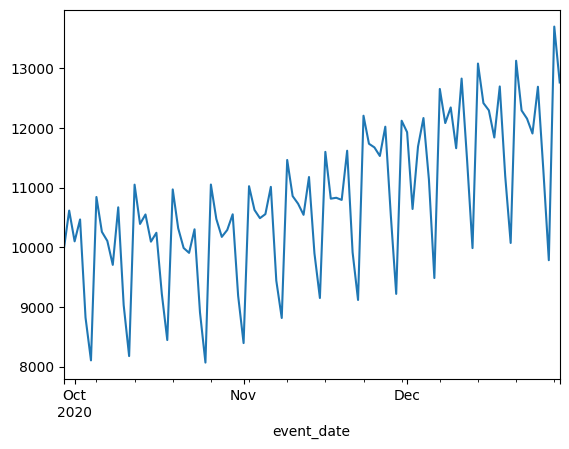

In [92]:
df_for_adv[df_for_adv['product'] == 'basic'].groupby('event_date')['user_id'].count().plot()

<Axes: xlabel='event_date'>

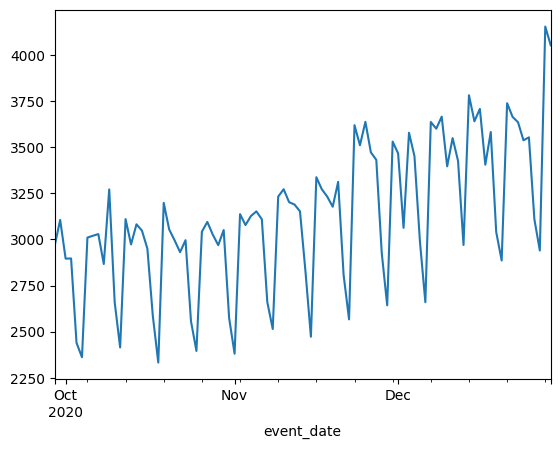

In [93]:
df_for_adv[df_for_adv['product'] == 'advanced'].groupby('event_date')['user_id'].count().plot()

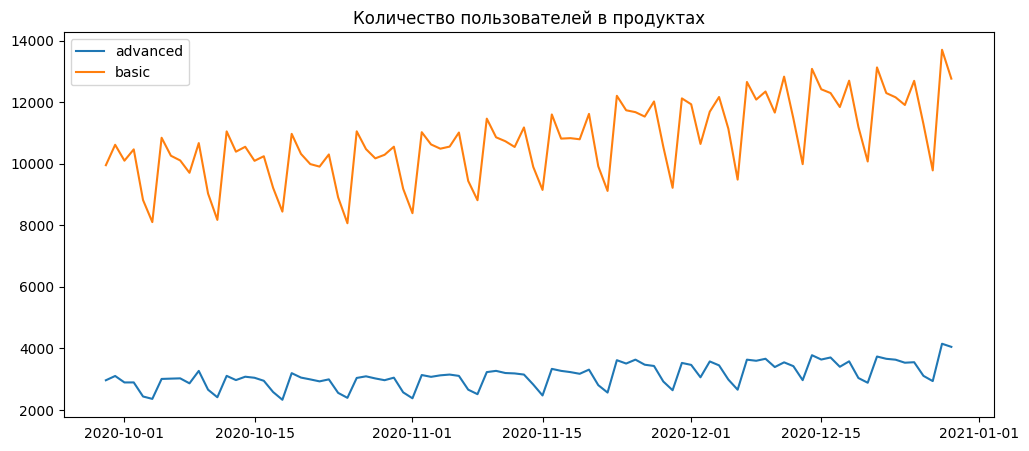

In [94]:
y1 = df_for_adv[df_for_adv['product'] == 'advanced'].groupby('event_date')['user_id'].count().reset_index()
y2 = df_for_adv[df_for_adv['product'] == 'basic'].groupby('event_date')['user_id'].count().reset_index()


plt.figure(figsize=(12, 5))
plt.title('Количество пользователей в продуктах')
plt.plot(y1['event_date'], y1['user_id'], label='advanced')
plt.plot(y1['event_date'], y2['user_id'], label='basic')
plt.legend(loc='best')

Опять же видим недельную сезональность.

In [95]:
y1.describe()

,event_date,user_id
count,92,92.000000
mean,2020-11-13 12:00:00,3127.804348
min,2020-09-29 00:00:00,2333.000000
25%,2020-10-21 18:00:00,2929.750000
50%,2020-11-13 12:00:00,3100.500000
75%,2020-12-06 06:00:00,3436.000000
max,2020-12-29 00:00:00,4153.000000
std,NaN,395.719382


In [96]:
transactions.transactions.mean()

1.1209709898886795

### Формализуем гипотезы

Мы определились, что мы хотим сравнивать среднюю прибыль на пользователя в день, количество транзакций на пользователя в день, а также среднее количество пользователей за день, использующие продукт 'advanced'

Метрика $ARPU$ per day:

$ H_0: \mathbb{E}[$RPU per day$] = 164.9912$

$ H_1: \mathbb{E}[$RPU per day$] > 164.9912 $

Метрика средние транзакции на 1 пользователя:

$ H_0: \mathbb{E}[$Trans per user per day$] = 1.12$

$ H_1: \mathbb{E}[$Trans per user per day$] > 1.12 $

Метрика среднее количество пользователей за день, использующие продукт 'advanced':

$ H_0: \mathbb{E}[$Users used 'advanced'$] = 3127.804348$

$ H_1: \mathbb{E}[$Users used 'advanced'$] > 3127.804348$

Предположим, что мы ожидаем рост этих статистик в 5%

In [97]:
mean = revenue.amount.mean()
std = revenue.amount.std()

alpha = 0.01 
power = 0.8
result_effect = 0.03
effect_size = (mean * result_effect) / std

In [98]:
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='larger')

C:\Users\lubin\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)


In [99]:
sample_vol

43.316306735099424

Выборка, которая нам нужна это средняя прибыль с одного юзера за день. Нам нужен объем выборки в 43.3, то есть надо 44 дня примерно на эксперимент. Если домножить на среднее количество юзеров в день, то в районе 440к записей необходимо. Это оценка.

Давайте выберем меньшее количество записей предположим из генеральной совокупности. Просто случайно выбрав юзеров из генеральной выборки. 

Напишем функцию, которая будет генерить выборки для наших метрик, она принимает исходные датасеты (разные для метрик прибыли и транзакций и для продвинутых пользователей, так как значения, которые мы сочли за выбросы в первых двух метриках, это не выбросы для третьей, так как продвинутые действительно платят больше), дату - по умолчанию стоит дата последнего наблюдения, отбирает юзеров случайно путем взятия модуля от id и фильтра. (Я думаю, что именно здесь нужно применять стратификацию, так как basic и advanced могут неравномерно разделиться, но я не придумал как это лучше сделать - надеюсь расскажут на занятии потом :) ) 

In [138]:
def choose_data(df=df, df_for_adv=df_for_adv, date=df.event_date.max(), delta=15, share=0.1):
    tmp = df[(df.event_date >= date - datetime.timedelta(days=delta)) & (df.event_date <= date) & (df.user_id % 100 <= int(100*share))] 
    revenue = tmp[['amount', 'event_date']].groupby('event_date').sum().reset_index()
    users = tmp[['user_id', 'event_date']].groupby('event_date').nunique().reset_index()
    revenue['amount'] /= users['user_id']
    transactions = tmp[['transactions', 'event_date']].groupby('event_date').sum().reset_index()
    transactions['transactions'] /= users['user_id']
    tmp_ = df_for_adv[(df_for_adv.event_date >= date - datetime.timedelta(days=delta)) & (df_for_adv.event_date <= date) & (df_for_adv.user_id % 100 <= int(100*share))]
    y1 = tmp_[tmp_['product'] == 'advanced'].groupby('event_date')['user_id'].count().reset_index()
    return revenue, transactions, y1, users, tmp.shape[0]

Выставим желаемые параметры

In [147]:
alpha = 0.01 
power = 0.8
result_effect = 0.02

In [156]:
rev, trans, adv, users, tmp_shape = choose_data(delta=60, share=0.4)

И посмотрим на оценки необходимого объема выборки для достижения этих параметров

In [157]:
mean_rev = rev.amount.mean()
std_rev = rev.amount.std()
effect_size = (mean_rev * result_effect) / std_rev
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='larger')

print('REVENUE')
print(f"effect_size = {effect_size}, sample_vol = {sample_vol} (дней), Оценка на количество записей: {sample_vol * users.user_id.mean()}")
print(sample_vol * users.user_id.mean() / tmp_shape)

REVENUE
effect_size = 0.42747527284218595, sample_vol = 111.20556643671821 (дней), Оценка на количество записей: 482318.59509884694
1.8144283251280808


C:\Users\lubin\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)


получили, что для достижения желаемого эффекта на метрику средней прибыли на 1 пользователя за 1 день необходимо 111 дней для проведения эксперимента.

Проделаем то же самое для остальных двух метрик

In [168]:
alpha = 0.01 
power = 0.8
result_effect = 0.005
rev, trans, adv, users, tmp_shape = choose_data(delta=60, share=0.4)

In [169]:
mean_trans = trans.transactions.mean()
std_trans = trans.transactions.std()
effect_size = (mean_trans * result_effect) / std_trans
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='larger')

print('TRANSACTIONS')
print(f"effect_size = {effect_size}, sample_vol = {sample_vol} (дней), Оценка на количество записей: {sample_vol * users.user_id.mean()}")
print(sample_vol * users.user_id.mean() / tmp_shape)

TRANSACTIONS
effect_size = 0.522509432096779, sample_vol = 74.88787066240465 (дней), Оценка на количество записей: 324802.1994329684
1.2218693550355437


C:\Users\lubin\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)


In [179]:
alpha = 0.01 
power = 0.8
result_effect = 0.05
rev, trans, adv, users, tmp_shape = choose_data(delta=60, share=0.4)

In [180]:
mean_adv = adv.user_id.mean()
std_adv = adv.user_id.std()
effect_size = (mean_adv * result_effect) / std_adv
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='larger')

print('ADVANCED USERS')
print(f"effect_size = {effect_size}, sample_vol = {sample_vol} (дней), Оценка на количество записей: {sample_vol * users.user_id.mean()}")

ADVANCED USERS
effect_size = 0.4008942550881852, sample_vol = 126.25328363437008 (дней), Оценка на количество записей: 547583.2581078364


C:\Users\lubin\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)


Итак, мы провели некоторое планирование желаемых результатов, наверное можно еще больше расширять выборку - в этом я здесь ничего страшного не вижу, так что после многочисленного варьирования мной желаемых параметров и параметров выборки, я получил значения выше/


К вопросу об оптимизации, возможно если что-то идет не так, значит надо менять result_effect и пересчитывать MDE in real time так сказать. Если мы имеем какой-то сильный разброс в выборке, а именно подозрительно большую std, то мы как-то не хорошо выборку выбрали, но это уже ошибки планирования, возможно мы разбили перекошеную выборку